In [34]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from datetime import datetime
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)

# Optional Advanced Libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost loaded")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not available")
    
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✓ LightGBM loaded")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️  LightGBM not available")

# Initialize global variables
models = {}
results = {}

print("\n✓ All libraries loaded!")

✓ XGBoost loaded
✓ LightGBM loaded

✓ All libraries loaded!


In [35]:
# Load TESS Objects of Interest
try:
    toi_df = pd.read_csv('TOI.csv')
    print(f"✓ TESS (TOI) loaded: {toi_df.shape}")
except FileNotFoundError:
    print("❌ TOI.csv not found")
    toi_df = None

# Load Kepler Objects of Interest  
try:
    koi_df = pd.read_csv('koi.csv')
    print(f"✓ Kepler (KOI) loaded: {koi_df.shape}")
except FileNotFoundError:
    print("❌ koi.csv not found")
    koi_df = None

# Load K2 Objects of Interest
try:
    k2_df = pd.read_csv('k2oi.csv')
    print(f"✓ K2 loaded: {k2_df.shape}")
except FileNotFoundError:
    print("❌ k2oi.csv not found")
    k2_df = None

print("\n✓ Dataset loading complete!")

✓ TESS (TOI) loaded: (7699, 87)
✓ Kepler (KOI) loaded: (9564, 141)
✓ K2 loaded: (4004, 295)

✓ Dataset loading complete!


In [36]:
def analyze_dataset(df, dataset_name, target_col):
    """Comprehensive dataset analysis"""
    if df is None:
        print(f"⚠️  {dataset_name} not available\n")
        return
    
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} DATASET ANALYSIS")
    print(f"{'='*80}")
    
    print(f"\n1. SHAPE: {df.shape[0]:,} rows × {df.shape[1]} columns")
    
    print(f"\n2. FIRST FEW ROWS:")
    display(df.head(3))
    
    print(f"\n3. TARGET COLUMN ({target_col}) VALUE COUNTS:")
    if target_col in df.columns:
        print(df[target_col].value_counts())
        print(f"\nNon-null: {df[target_col].notna().sum():,} ({100*df[target_col].notna().sum()/len(df):.1f}%)")
    else:
        print(f"❌ Column '{target_col}' not found")
        print(f"Available columns: {df.columns.tolist()[:10]}...")
    
    print(f"\n4. MISSING VALUES (Top 10):")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
    display(missing_df[missing_df['Count'] > 0].sort_values('Count', ascending=False).head(10))

# Analyze each dataset
if toi_df is not None:
    analyze_dataset(toi_df, 'TESS', 'tfopwg_disp')

if koi_df is not None:
    analyze_dataset(koi_df, 'Kepler', 'koi_disposition')

if k2_df is not None:
    analyze_dataset(k2_df, 'K2', 'disposition')


TESS DATASET ANALYSIS

1. SHAPE: 7,699 rows × 87 columns

2. FIRST FEW ROWS:


,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,raerr1,...,st_loggerr2,st_logglim,st_loggsymerr,st_rad,st_raderr1,st_raderr2,st_radlim,st_radsymerr,toi_created,rowupdate
0,1,1000.01,1000,50365310,5.036531e+07,1,FP,07h29m25.85s,112.357708,NaN,...,-0.07,0,1,2.16986,0.072573,-0.072573,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01
1,2,1001.01,1001,88863718,8.886372e+07,1,PC,08h10m19.31s,122.580465,NaN,...,-0.09,0,1,2.01000,0.090000,-0.090000,0,1,2019-07-24 15:58:33,2023-04-03 14:31:04
2,3,1002.01,1002,124709665,1.247097e+08,1,FP,06h58m54.47s,104.726966,NaN,...,NaN,0,1,5.73000,NaN,NaN,0,1,2019-07-24 15:58:33,2022-07-11 16:02:02



3. TARGET COLUMN (tfopwg_disp) VALUE COUNTS:
tfopwg_disp
PC     4678
FP     1196
CP      683
KP      583
APC     461
FA       98
Name: count, dtype: int64

Non-null: 7,699 (100.0%)

4. MISSING VALUES (Top 10):


,Count,Percentage
raerr1,7699,100.0
raerr2,7699,100.0
decerr1,7699,100.0
decerr2,7699,100.0
pl_insolerr1,7699,100.0
pl_insolsymerr,7699,100.0
pl_insollim,7699,100.0
pl_insolerr2,7699,100.0
pl_eqterr1,7699,100.0
pl_eqterr2,7699,100.0



KEPLER DATASET ANALYSIS

1. SHAPE: 9,564 rows × 141 columns

2. FIRST FEW ROWS:


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.16,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.48,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.07,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074



3. TARGET COLUMN (koi_disposition) VALUE COUNTS:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

Non-null: 9,564 (100.0%)

4. MISSING VALUES (Top 10):


,Count,Percentage
koi_ingress_err1,9564,100.0
koi_ingress_err2,9564,100.0
koi_ingress,9564,100.0
koi_longp_err2,9564,100.0
koi_longp,9564,100.0
koi_longp_err1,9564,100.0
koi_eccen_err1,9564,100.0
koi_eccen_err2,9564,100.0
koi_incl_err2,9564,100.0
koi_sma_err2,9564,100.0



K2 DATASET ANALYSIS

1. SHAPE: 4,004 rows × 295 columns

2. FIRST FEW ROWS:


,rowid,pl_name,hostname,pl_letter,k2_name,epic_hostname,epic_candname,hd_name,hip_name,tic_id,...,releasedate,pl_nnotes,k2_campaigns,k2_campaigns_num,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2018-02-15,1,4,1.0,0,0,0,0,0,0
1,2,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2016-07-28,1,4,1.0,0,0,0,0,0,0
2,3,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2018-04-26,1,4,1.0,0,0,0,0,0,0



3. TARGET COLUMN (disposition) VALUE COUNTS:
disposition
CONFIRMED         2315
CANDIDATE         1374
FALSE POSITIVE     293
REFUTED             22
Name: count, dtype: int64

Non-null: 4,004 (100.0%)

4. MISSING VALUES (Top 10):


,Count,Percentage
pl_occdeperr2,4004,100.000000
pl_occdeperr1,4004,100.000000
sy_icmag,4004,100.000000
sy_icmagerr1,4004,100.000000
sy_kepmagerr2,4004,100.000000
sy_icmagerr2,4004,100.000000
sy_kepmagerr1,4004,100.000000
pl_occdep,4003,99.975025
pl_occdeplim,4003,99.975025
pl_trueobliqerr1,3994,99.750250


In [37]:
# ==================== CHOOSE YOUR DATASET ====================
# Options: 'KEPLER', 'TESS', or 'K2'
dataset_choice = 'K2'  # ⬅️ CHANGE THIS TO SELECT DATASET
# =============================================================

dataset_map = {
    'KEPLER': {
        'name': 'Kepler',
        'target': 'koi_disposition',
        'df': koi_df,
        'features': [
            'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth',
            'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr',
            'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag'
        ]
    },
    'TESS': {
        'name': 'TESS',
        'target': 'tfopwg_disp',
        'df': toi_df,
        'features': [
            'pl_orbper', 'pl_rade', 'pl_bmasse', 'pl_dens', 'pl_orbsmax',
            'pl_orbeccen', 'pl_insol', 'pl_eqt', 'st_teff', 'st_rad',
            'st_mass', 'st_logg', 'sy_dist', 'sy_vmag'
        ]
    },
    'K2': {
        'name': 'K2',
        'target': 'disposition',
        'df': k2_df,
        'features': [
            'pl_orbper', 'pl_rade', 'pl_bmasse', 'pl_dens', 'pl_orbsmax',
            'pl_orbeccen', 'pl_insol', 'pl_eqt', 'st_teff', 'st_rad',
            'st_mass', 'st_logg'
        ]
    }
}

# Extract configuration
config = dataset_map[dataset_choice]
df_work = config['df'].copy()
target_col = config['target']
selected_features = config['features']
dataset_name = config['name']

# Check feature availability
available_features = [col for col in selected_features if col in df_work.columns]
missing_features = [col for col in selected_features if col not in df_work.columns]

print(f"\n{'='*80}")
print(f"DATASET: {dataset_name}")
print(f"Target Column: {target_col}")
print(f"{'='*80}")
print(f"Requested features: {len(selected_features)}")
print(f"Available features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")
if missing_features:
    print(f"Missing: {missing_features}")

# Create clean dataset
df_clean = df_work[[target_col] + available_features].copy()
print(f"\n✓ Clean dataset created: {df_clean.shape}")


DATASET: K2
Target Column: disposition
Requested features: 12
Available features: 12
Missing features: 0

✓ Clean dataset created: (4004, 13)


In [38]:
def check_ml_eligibility(df, target_col, feature_cols, dataset_name):
    """Comprehensive ML readiness check"""
    print(f"\n{dataset_name} Dataset ML Eligibility Check:")
    print("-" * 60)
    
    # Check 1: Target column exists
    if target_col not in df.columns:
        print(f"❌ Target column '{target_col}' not found")
        return False
    print(f"✓ Target column '{target_col}' exists")
    
    # Check 2: Sufficient valid targets
    target_valid = df[target_col].notna().sum()
    print(f"✓ Valid target values: {target_valid:,} ({100*target_valid/len(df):.1f}%)")
    
    if target_valid < 100:
        print(f"❌ Too few valid targets (need ≥ 100)")
        return False
    
    # Check 3: Multiple classes
    n_classes = df[target_col].nunique()
    print(f"✓ Number of classes: {n_classes}")
    
    if n_classes < 2:
        print(f"❌ Need at least 2 classes")
        return False
    
    # Check 4: Features available
    print(f"✓ Features available: {len(feature_cols)}")
    
    if len(feature_cols) < 3:
        print(f"❌ Need at least 3 features")
        return False
    
    # Check 5: Class balance
    def simplify_target(value):
        if pd.isna(value):
            return np.nan
        value_str = str(value).upper()
        if any(x in value_str for x in ['CONFIRMED', 'CANDIDATE', 'PC', 'CP', 'KP']):
            return 1  # Planet
        else:
            return 0  # Not Planet
    
    df_temp = df.copy()
    df_temp['binary_target'] = df_temp[target_col].apply(simplify_target)
    df_temp = df_temp.dropna(subset=['binary_target'])
    
    if len(df_temp) < 100:
        print(f"❌ Too few samples after cleaning: {len(df_temp)}")
        return False
    
    class_counts = df_temp['binary_target'].value_counts()
    print(f"✓ Class distribution:")
    print(f"   Class 0 (Not Planet): {class_counts.get(0, 0):,}")
    print(f"   Class 1 (Planet): {class_counts.get(1, 0):,}")
    
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"✓ Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    # Check 6: Feature completeness
    avg_completeness = df[feature_cols].notna().mean().mean() * 100
    print(f"✓ Average feature completeness: {avg_completeness:.1f}%")
    
    print(f"\n{'✓ ELIGIBLE FOR ML' if True else '❌ NOT ELIGIBLE'}")
    return True

# Run eligibility check
is_eligible = check_ml_eligibility(df_clean, target_col, available_features, dataset_name)

if is_eligible:
    print(f"\n{'='*80}")
    print(f"✓✓✓ {dataset_name} Dataset is READY FOR ML! ✓✓✓")
    print(f"{'='*80}")
else:
    print("\n❌ Please select a different dataset or adjust features")


K2 Dataset ML Eligibility Check:
------------------------------------------------------------
✓ Target column 'disposition' exists
✓ Valid target values: 4,004 (100.0%)
✓ Number of classes: 4
✓ Features available: 12
✓ Class distribution:
   Class 0 (Not Planet): 315
   Class 1 (Planet): 3,689
✓ Imbalance ratio: 11.71:1
✓ Average feature completeness: 45.5%

✓ ELIGIBLE FOR ML

✓✓✓ K2 Dataset is READY FOR ML! ✓✓✓


In [39]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

# Create binary target
def simplify_target(value):
    if pd.isna(value):
        return np.nan
    value_str = str(value).upper()
    if any(x in value_str for x in ['CONFIRMED', 'CANDIDATE', 'PC', 'CP', 'KP']):
        return 1  # Planet
    else:
        return 0  # Not Planet

df_clean['target'] = df_clean[target_col].apply(simplify_target)
df_clean = df_clean.dropna(subset=['target'])
df_clean['target'] = df_clean['target'].astype(int)

print(f"Dataset after target creation: {df_clean.shape}")
print(f"\nTarget distribution:")
print(f"  Class 0 (Not Planet): {(df_clean['target']==0).sum():,}")
print(f"  Class 1 (Planet): {(df_clean['target']==1).sum():,}")

# Check class imbalance
class_counts = df_clean['target'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine if balanced weights needed (ANTI-OVERFITTING)
if imbalance_ratio > 10:
    use_balanced = True
    class_weight = 'balanced'
    print(f"  → Using class_weight='balanced' to prevent overfitting")
else:
    use_balanced = False
    class_weight = None
    print(f"  → Class balance is reasonable")

# Separate features and target
X = df_clean[available_features].copy()
y = df_clean['target'].copy()

print(f"\nInitial: X={X.shape}, y={y.shape}")

# Handle missing values with median (robust to outliers)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)
print(f"After imputation: {X_imputed.isnull().sum().sum()} missing values")

# Remove zero-variance features (ANTI-OVERFITTING)
selector = VarianceThreshold(threshold=0.001)
X_selected = pd.DataFrame(
    selector.fit_transform(X_imputed),
    columns=X_imputed.columns[selector.get_support()],
    index=X_imputed.index
)

removed = set(X_imputed.columns) - set(X_selected.columns)
if removed:
    print(f"\nRemoved {len(removed)} zero-variance features (prevents overfitting)")

# Standardize features (critical for preventing overfitting)
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_selected),
    columns=X_selected.columns,
    index=X_selected.index
)

print(f"\n{'='*80}")
print(f"PREPROCESSING COMPLETE (ANTI-OVERFITTING MEASURES APPLIED)")
print(f"{'='*80}")
print(f"Final: X={X_scaled.shape}, y={y.shape}")
print(f"Features: {list(X_scaled.columns)}")
print(f"\n✓ Data ready for training!")

Dataset after target creation: (4004, 14)

Target distribution:
  Class 0 (Not Planet): 315
  Class 1 (Planet): 3,689
  Imbalance ratio: 11.71:1
  → Using class_weight='balanced' to prevent overfitting

Initial: X=(4004, 12), y=(4004,)
After imputation: 0 missing values

PREPROCESSING COMPLETE (ANTI-OVERFITTING MEASURES APPLIED)
Final: X=(4004, 12), y=(4004,)
Features: ['pl_orbper', 'pl_rade', 'pl_bmasse', 'pl_dens', 'pl_orbsmax', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'st_teff', 'st_rad', 'st_mass', 'st_logg']

✓ Data ready for training!


In [40]:
# THREE-WAY SPLIT: Train (64%) / Test (16%) / Holdout (20%)
# Holdout set is NEVER touched during model development!

# First split: 80% for development, 20% for final holdout
X_main, X_holdout, y_main, y_holdout = train_test_split(
    X_scaled, y,
    test_size=0.2,  # 20% holdout
    random_state=42,
    stratify=y  # Maintains class distribution
)

# Second split: 80% train, 20% test from development set
X_train, X_test, y_train, y_test = train_test_split(
    X_main, y_main,
    test_size=0.2,  # 16% of total
    random_state=42,
    stratify=y_main
)

print(f"Data Split (Anti-Overfitting Strategy):")
print(f"{'='*60}")
print(f"Training:   {X_train.shape[0]:>6} samples ({100*len(X_train)/len(X_scaled):>5.1f}%)")
print(f"Test:       {X_test.shape[0]:>6} samples ({100*len(X_test)/len(X_scaled):>5.1f}%)")
print(f"Holdout:    {X_holdout.shape[0]:>6} samples ({100*len(X_holdout)/len(X_scaled):>5.1f}%)")
print(f"{'='*60}")

# Verify stratification
print(f"\nClass Distribution Verification:")
print(f"Train:   {(y_train==1).sum()}/{len(y_train)} planets ({100*(y_train==1).sum()/len(y_train):.1f}%)")
print(f"Test:    {(y_test==1).sum()}/{len(y_test)} planets ({100*(y_test==1).sum()/len(y_test):.1f}%)")
print(f"Holdout: {(y_holdout==1).sum()}/{len(y_holdout)} planets ({100*(y_holdout==1).sum()/len(y_holdout):.1f}%)")

print("\n✓ HOLDOUT SET LOCKED - Will only be used for final validation!")

Data Split (Anti-Overfitting Strategy):
Training:     2562 samples ( 64.0%)
Test:          641 samples ( 16.0%)
Holdout:       801 samples ( 20.0%)

Class Distribution Verification:
Train:   2360/2562 planets (92.1%)
Test:    591/641 planets (92.2%)
Holdout: 738/801 planets (92.1%)

✓ HOLDOUT SET LOCKED - Will only be used for final validation!


In [41]:
print(f"{'='*80}")
print(f"TRAINING MODELS WITH ANTI-OVERFITTING REGULARIZATION")
print(f"{'='*80}\n")

# 1. Logistic Regression (L2 regularization)
print("1. Training Logistic Regression (L2 regularized)...")
lr = LogisticRegression(
    random_state=42, 
    max_iter=1000, 
    class_weight=class_weight,
    C=1.0  # Regularization strength
)
lr.fit(X_train, y_train)
models['Logistic Regression'] = lr
lr_pred = lr.predict(X_test)
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
results['Logistic Regression'] = {'accuracy': accuracy_score(y_test, lr_pred), 'auc': lr_auc}
print(f"   Test Accuracy: {results['Logistic Regression']['accuracy']:.4f} | AUC: {lr_auc:.4f}")

# 2. Decision Tree (max_depth limits overfitting)
print("\n2. Training Decision Tree (depth-limited)...")
dt = DecisionTreeClassifier(
    random_state=42, 
    max_depth=10,  # Prevents overfitting
    min_samples_split=20,  # Anti-overfitting
    min_samples_leaf=10,  # Anti-overfitting
    class_weight=class_weight
)
dt.fit(X_train, y_train)
models['Decision Tree'] = dt
dt_pred = dt.predict(X_test)
dt_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
results['Decision Tree'] = {'accuracy': accuracy_score(y_test, dt_pred), 'auc': dt_auc}
print(f"   Test Accuracy: {results['Decision Tree']['accuracy']:.4f} | AUC: {dt_auc:.4f}")

# 3. Random Forest (built-in regularization)
print("\n3. Training Random Forest (regularized)...")
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    max_depth=15,  # Prevents overfitting
    min_samples_split=10,  # Anti-overfitting
    min_samples_leaf=5,  # Anti-overfitting
    max_features='sqrt',  # Reduces correlation
    class_weight=class_weight
)
rf.fit(X_train, y_train)
models['Random Forest'] = rf
rf_pred = rf.predict(X_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
results['Random Forest'] = {'accuracy': accuracy_score(y_test, rf_pred), 'auc': rf_auc}
print(f"   Test Accuracy: {results['Random Forest']['accuracy']:.4f} | AUC: {rf_auc:.4f}")

# 4. Gradient Boosting (learning_rate prevents overfitting)
print("\n4. Training Gradient Boosting (regularized)...")
gb = GradientBoostingClassifier(
    n_estimators=100, 
    random_state=42,
    learning_rate=0.1,  # Slower learning = less overfitting
    max_depth=5,  # Shallow trees
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8  # Stochastic boosting
)
gb.fit(X_train, y_train)
models['Gradient Boosting'] = gb
gb_pred = gb.predict(X_test)
gb_auc = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
results['Gradient Boosting'] = {'accuracy': accuracy_score(y_test, gb_pred), 'auc': gb_auc}
print(f"   Test Accuracy: {results['Gradient Boosting']['accuracy']:.4f} | AUC: {gb_auc:.4f}")

# 5. K-Nearest Neighbors
print("\n5. Training K-Nearest Neighbors...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
models['KNN'] = knn
knn_pred = knn.predict(X_test)
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
results['KNN'] = {'accuracy': accuracy_score(y_test, knn_pred), 'auc': knn_auc}
print(f"   Test Accuracy: {results['KNN']['accuracy']:.4f} | AUC: {knn_auc:.4f}")

# 6. SVM (C parameter controls overfitting)
print("\n6. Training SVM (regularized)...")
svm = SVC(
    kernel='rbf', 
    probability=True, 
    random_state=42,
    C=1.0,  # Regularization
    gamma='scale',  # Auto-scaling
    class_weight=class_weight
)
svm.fit(X_train, y_train)
models['SVM'] = svm
svm_pred = svm.predict(X_test)
svm_auc = roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1])
results['SVM'] = {'accuracy': accuracy_score(y_test, svm_pred), 'auc': svm_auc}
print(f"   Test Accuracy: {results['SVM']['accuracy']:.4f} | AUC: {svm_auc:.4f}")

# 7. Naive Bayes
print("\n7. Training Naive Bayes...")
nb = GaussianNB()
nb.fit(X_train, y_train)
models['Naive Bayes'] = nb
nb_pred = nb.predict(X_test)
nb_auc = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
results['Naive Bayes'] = {'accuracy': accuracy_score(y_test, nb_pred), 'auc': nb_auc}
print(f"   Test Accuracy: {results['Naive Bayes']['accuracy']:.4f} | AUC: {nb_auc:.4f}")

# 8. XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("\n8. Training XGBoost (regularized)...")
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() if use_balanced else 1
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        learning_rate=0.1,  # Regularization
        max_depth=5,  # Prevents overfitting
        min_child_weight=3,  # Anti-overfitting
        subsample=0.8,  # Stochastic training
        colsample_bytree=0.8,  # Feature sampling
        reg_alpha=0.1,  # L1 regularization
        reg_lambda=1.0,  # L2 regularization
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    models['XGBoost'] = xgb_model
    xgb_pred = xgb_model.predict(X_test)
    xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
    results['XGBoost'] = {'accuracy': accuracy_score(y_test, xgb_pred), 'auc': xgb_auc}
    print(f"   Test Accuracy: {results['XGBoost']['accuracy']:.4f} | AUC: {xgb_auc:.4f}")

# 9. LightGBM (if available)
if LIGHTGBM_AVAILABLE:
    print("\n9. Training LightGBM (regularized)...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        random_state=42,
        learning_rate=0.1,
        max_depth=5,
        num_leaves=31,
        min_child_samples=20,  # Anti-overfitting
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,  # L1
        reg_lambda=1.0,  # L2
        class_weight=class_weight,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    models['LightGBM'] = lgb_model
    lgb_pred = lgb_model.predict(X_test)
    lgb_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1])
    results['LightGBM'] = {'accuracy': accuracy_score(y_test, lgb_pred), 'auc': lgb_auc}
    print(f"   Test Accuracy: {results['LightGBM']['accuracy']:.4f} | AUC: {lgb_auc:.4f}")

print(f"\n{'='*80}")
print(f"✓ All models trained with anti-overfitting measures!")
print(f"{'='*80}")

TRAINING MODELS WITH ANTI-OVERFITTING REGULARIZATION

1. Training Logistic Regression (L2 regularized)...
   Test Accuracy: 0.7223 | AUC: 0.7124

2. Training Decision Tree (depth-limited)...
   Test Accuracy: 0.8440 | AUC: 0.7963

3. Training Random Forest (regularized)...
   Test Accuracy: 0.9017 | AUC: 0.9000

4. Training Gradient Boosting (regularized)...
   Test Accuracy: 0.9376 | AUC: 0.9057

5. Training K-Nearest Neighbors...
   Test Accuracy: 0.9267 | AUC: 0.7973

6. Training SVM (regularized)...
   Test Accuracy: 0.7707 | AUC: 0.8094

7. Training Naive Bayes...
   Test Accuracy: 0.2777 | AUC: 0.7444

8. Training XGBoost (regularized)...
   Test Accuracy: 0.8565 | AUC: 0.8729

9. Training LightGBM (regularized)...
   Test Accuracy: 0.8939 | AUC: 0.9100

✓ All models trained with anti-overfitting measures!



Model Rankings (by AUC):
                     accuracy       auc
LightGBM             0.893916  0.909983
Gradient Boosting    0.937598  0.905685
Random Forest        0.901716  0.900000
XGBoost              0.856474  0.872860
SVM                  0.770671  0.809442
KNN                  0.926677  0.797276
Decision Tree        0.843994  0.796261
Naive Bayes          0.277691  0.744433
Logistic Regression  0.722309  0.712352


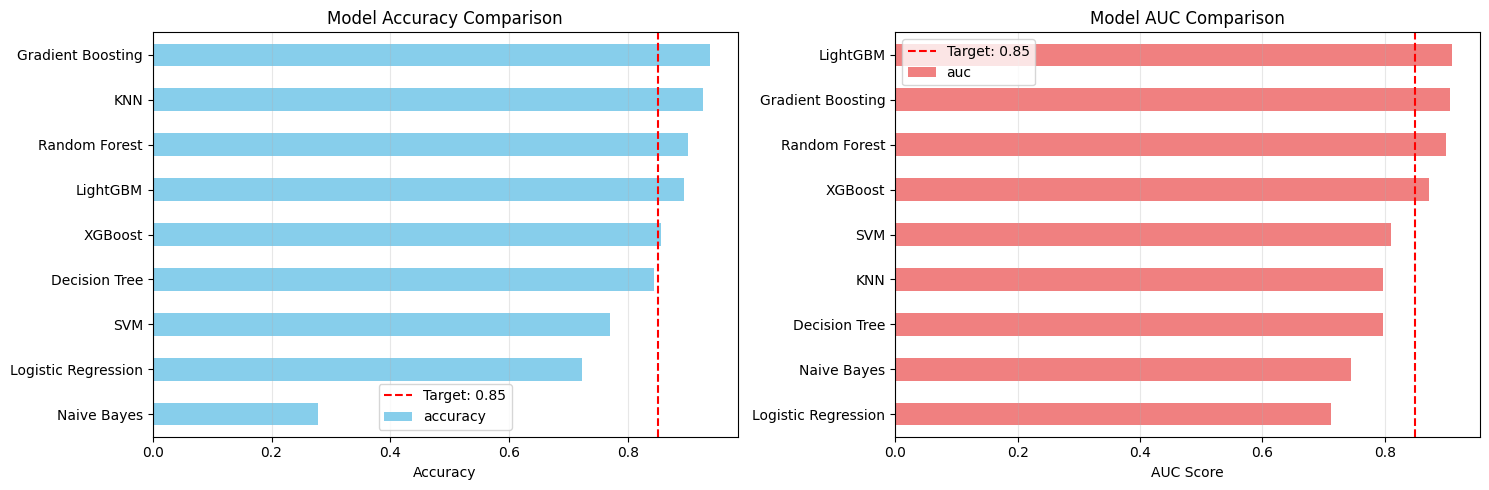


BEST SINGLE MODEL: LightGBM
Accuracy: 0.8939 | AUC: 0.9100


In [42]:
# Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('auc', ascending=False)

print("\nModel Rankings (by AUC):")
print("="*60)
print(results_df.to_string())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

results_df['accuracy'].sort_values().plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].axvline(x=0.85, color='red', linestyle='--', label='Target: 0.85')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

results_df['auc'].sort_values().plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_xlabel('AUC Score')
axes[1].set_title('Model AUC Comparison')
axes[1].axvline(x=0.85, color='red', linestyle='--', label='Target: 0.85')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

best_model_name = results_df.index[0]
best_auc = results_df['auc'].iloc[0]
best_acc = results_df['accuracy'].iloc[0]

print(f"\n{'='*80}")
print(f"BEST SINGLE MODEL: {best_model_name}")
print(f"Accuracy: {best_acc:.4f} | AUC: {best_auc:.4f}")
print(f"{'='*80}")

In [43]:
# Select top 5 models for ensemble
top_n = min(5, len(models))
top_model_names = list(results_df.head(top_n).index)

print(f"Creating ensemble from top {top_n} models:")
for i, name in enumerate(top_model_names, 1):
    print(f"  {i}. {name} (AUC: {results_df.loc[name, 'auc']:.4f})")

# Create ensemble
estimators = [(name, models[name]) for name in top_model_names]
ensemble = VotingClassifier(estimators=estimators, voting='soft')

print(f"\nTraining ensemble...")
ensemble.fit(X_train, y_train)

# Evaluate on TEST set
ensemble_pred = ensemble.predict(X_test)
ensemble_proba = ensemble.predict_proba(X_test)[:, 1]

ensemble_acc = accuracy_score(y_test, ensemble_pred)
ensemble_precision = precision_score(y_test, ensemble_pred)
ensemble_recall = recall_score(y_test, ensemble_pred)
ensemble_f1 = f1_score(y_test, ensemble_pred)
ensemble_auc = roc_auc_score(y_test, ensemble_proba)

print(f"\n{'='*80}")
print(f"ENSEMBLE MODEL PERFORMANCE (TEST SET)")
print(f"{'='*80}")
print(f"Accuracy:  {ensemble_acc:.4f}")
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall:    {ensemble_recall:.4f}")
print(f"F1 Score:  {ensemble_f1:.4f}")
print(f"AUC Score: {ensemble_auc:.4f}")

if ensemble_auc >= 0.85:
    print(f"\n✓✓✓ SUCCESS! Ensemble AUC >= 0.85 ✓✓✓")
else:
    print(f"\n⚠️  Ensemble AUC: {ensemble_auc:.4f} (Target: 0.85)")

# Add to results
models['Ensemble'] = ensemble
results['Ensemble'] = {
    'accuracy': ensemble_acc,
    'precision': ensemble_precision,
    'recall': ensemble_recall,
    'f1': ensemble_f1,
    'auc': ensemble_auc
}

Creating ensemble from top 5 models:
  1. LightGBM (AUC: 0.9100)
  2. Gradient Boosting (AUC: 0.9057)
  3. Random Forest (AUC: 0.9000)
  4. XGBoost (AUC: 0.8729)
  5. SVM (AUC: 0.8094)

Training ensemble...

ENSEMBLE MODEL PERFORMANCE (TEST SET)
Accuracy:  0.9236
Precision: 0.9609
Recall:    0.9560
F1 Score:  0.9584
AUC Score: 0.9021

✓✓✓ SUCCESS! Ensemble AUC >= 0.85 ✓✓✓


In [44]:
# Use StratifiedKFold for better anti-overfitting validation
print("Performing 5-Fold Stratified Cross-Validation...")
print("="*60)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# CV on training data only (not touching test/holdout)
cv_scores = cross_val_score(
    ensemble, 
    X_train,  # Only training data!
    y_train, 
    cv=skf, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"Model: Ensemble")
print(f"\nCross-Validation AUC Scores (Training Set Only):")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMean CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Min CV AUC:  {cv_scores.min():.4f}")
print(f"Max CV AUC:  {cv_scores.max():.4f}")

# Check for overfitting
train_test_gap = cv_scores.mean() - ensemble_auc
print(f"\n{'='*60}")
print(f"OVERFITTING CHECK:")
print(f"  CV AUC (train):     {cv_scores.mean():.4f}")
print(f"  Test AUC:           {ensemble_auc:.4f}")
print(f"  Gap:                {abs(train_test_gap):.4f}")

if abs(train_test_gap) < 0.05:
    print(f"  ✓ Good generalization - No overfitting detected!")
elif abs(train_test_gap) < 0.10:
    print(f"  ⚠️  Slight overfitting - Acceptable")
else:
    print(f"  ❌ Significant overfitting detected!")

print(f"{'='*60}")

Performing 5-Fold Stratified Cross-Validation...
Model: Ensemble

Cross-Validation AUC Scores (Training Set Only):
  Fold 1: 0.9372
  Fold 2: 0.9311
  Fold 3: 0.8958
  Fold 4: 0.9267
  Fold 5: 0.8952

Mean CV AUC: 0.9172 ± 0.0180
Min CV AUC:  0.8952
Max CV AUC:  0.9372

OVERFITTING CHECK:
  CV AUC (train):     0.9172
  Test AUC:           0.9021
  Gap:                0.0151
  ✓ Good generalization - No overfitting detected!



FINAL VALIDATION ON UNSEEN HOLDOUT SET
⚠️  This set was NEVER used during training/tuning!

HOLDOUT SET RESULTS:
Accuracy:  0.9276
Precision: 0.9658
Recall:    0.9553
F1 Score:  0.9605
AUC Score: 0.9278

🎉🎉🎉 SUCCESS! HOLDOUT AUC >= 0.85 🎉🎉🎉
Model generalizes well to completely unseen data!


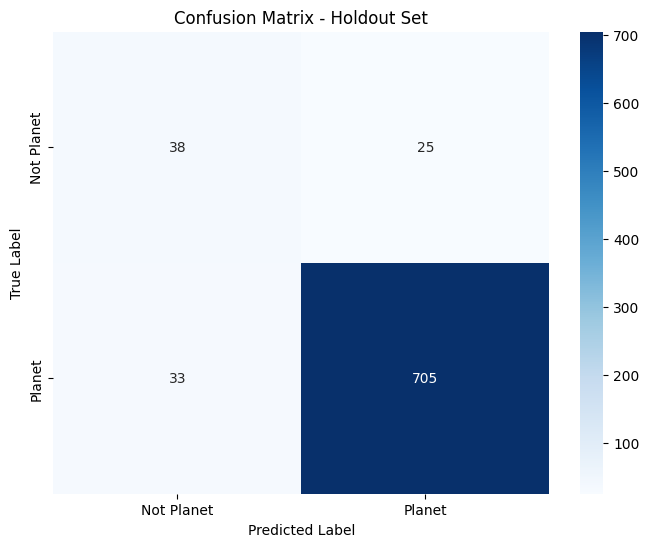

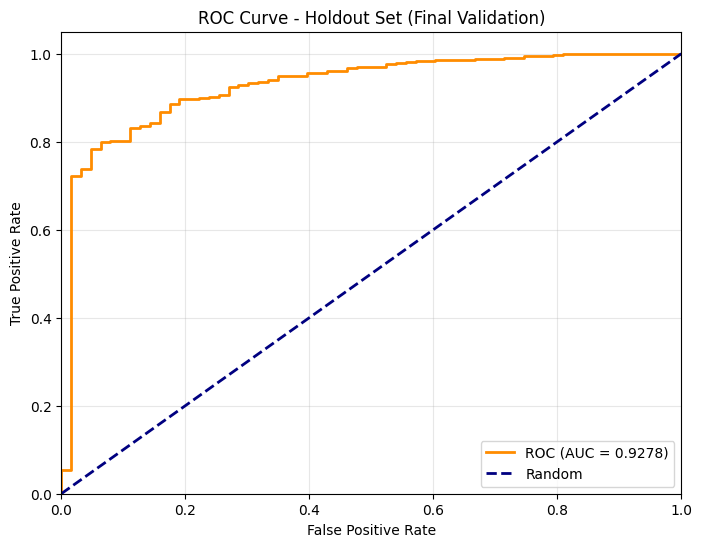


✓ Final validation complete!


In [45]:
print(f"\n{'='*80}")
print(f"FINAL VALIDATION ON UNSEEN HOLDOUT SET")
print(f"{'='*80}")
print(f"⚠️  This set was NEVER used during training/tuning!\n")

# Predict on holdout
holdout_pred = ensemble.predict(X_holdout)
holdout_proba = ensemble.predict_proba(X_holdout)[:, 1]

# Calculate metrics
holdout_acc = accuracy_score(y_holdout, holdout_pred)
holdout_precision = precision_score(y_holdout, holdout_pred)
holdout_recall = recall_score(y_holdout, holdout_pred)
holdout_f1 = f1_score(y_holdout, holdout_pred)
holdout_auc = roc_auc_score(y_holdout, holdout_proba)

print(f"HOLDOUT SET RESULTS:")
print(f"="*60)
print(f"Accuracy:  {holdout_acc:.4f}")
print(f"Precision: {holdout_precision:.4f}")
print(f"Recall:    {holdout_recall:.4f}")
print(f"F1 Score:  {holdout_f1:.4f}")
print(f"AUC Score: {holdout_auc:.4f}")
print(f"="*60)

if holdout_auc >= 0.85:
    print(f"\n🎉🎉🎉 SUCCESS! HOLDOUT AUC >= 0.85 🎉🎉🎉")
    print(f"Model generalizes well to completely unseen data!")
else:
    print(f"\n⚠️  Holdout AUC: {holdout_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_holdout, holdout_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Planet', 'Planet'],
            yticklabels=['Not Planet', 'Planet'])
plt.title(f'Confusion Matrix - Holdout Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_holdout, holdout_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC (AUC = {holdout_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Holdout Set (Final Validation)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print("\n✓ Final validation complete!")

In [46]:
# Create export directory
export_dir = 'model_export'
os.makedirs(export_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"Exporting model for Streamlit deployment...")
print(f"="*60)

# 1. Save the ensemble model
model_path = f'{export_dir}/exoplanet_ensemble_model.joblib'
joblib.dump(ensemble, model_path)
print(f"✓ Model saved: {model_path}")

# 2. Save the scaler
scaler_path = f'{export_dir}/feature_scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved: {scaler_path}")

# 3. Save the imputer
imputer_path = f'{export_dir}/feature_imputer.joblib'
joblib.dump(imputer, imputer_path)
print(f"✓ Imputer saved: {imputer_path}")

# 4. Save variance selector
selector_path = f'{export_dir}/variance_selector.joblib'
joblib.dump(selector, selector_path)
print(f"✓ Variance selector saved: {selector_path}")

# 5. Save feature names
feature_info = {
    'original_features': available_features,  # Original feature names
    'selected_features': list(X_scaled.columns),  # After variance filtering
    'target_name': target_col,
    'dataset_name': dataset_name,
    'n_features': len(X_scaled.columns),
    'model_timestamp': timestamp
}
feature_path = f'{export_dir}/feature_info.joblib'
joblib.dump(feature_info, feature_path)
print(f"✓ Feature info saved: {feature_path}")

# 6. Save performance metrics
metrics = {
    'test_accuracy': ensemble_acc,
    'test_auc': ensemble_auc,
    'test_f1': ensemble_f1,
    'holdout_accuracy': holdout_acc,
    'holdout_auc': holdout_auc,
    'holdout_f1': holdout_f1,
    'cv_mean_auc': cv_scores.mean(),
    'cv_std_auc': cv_scores.std(),
    'top_models': top_model_names,
    'trained_on': dataset_name,
    'timestamp': timestamp,
    'class_distribution': {
        'train_planets': int((y_train==1).sum()),
        'train_total': int(len(y_train)),
        'test_planets': int((y_test==1).sum()),
        'test_total': int(len(y_test))
    }
}
metrics_path = f'{export_dir}/model_metrics.joblib'
joblib.dump(metrics, metrics_path)
print(f"✓ Metrics saved: {metrics_path}")

# 7. Create CSV template for batch predictions
template_df = pd.DataFrame(columns=available_features)
template_path = f'{export_dir}/input_template.csv'
template_df.to_csv(template_path, index=False)
print(f"✓ CSV template saved: {template_path}")

print(f"\n{'='*60}")
print(f"✓✓✓ MODEL EXPORT COMPLETE! ✓✓✓")
print(f"{'='*60}")
print(f"\nAll files saved to: {export_dir}/")
print(f"\nReady for Streamlit deployment!")

Exporting model for Streamlit deployment...
✓ Model saved: model_export/exoplanet_ensemble_model.joblib
✓ Scaler saved: model_export/feature_scaler.joblib
✓ Imputer saved: model_export/feature_imputer.joblib
✓ Variance selector saved: model_export/variance_selector.joblib
✓ Feature info saved: model_export/feature_info.joblib
✓ Metrics saved: model_export/model_metrics.joblib
✓ CSV template saved: model_export/input_template.csv

✓✓✓ MODEL EXPORT COMPLETE! ✓✓✓

All files saved to: model_export/

Ready for Streamlit deployment!


In [48]:
print(f"\n{'='*80}")
print(f"FINAL PROJECT SUMMARY - NASA SPACE APPS 2025")
print(f"{'='*80}\n")

print(f"Dataset: {dataset_name}")
print(f"Total Samples: {len(X_scaled):,}")
print(f"Features: {X_scaled.shape[1]}")
print(f"Training: {len(X_train):,} | Test: {len(X_test):,} | Holdout: {len(X_holdout):,}")

print(f"\n{'='*80}")
print(f"MODEL PERFORMANCE")
print(f"{'='*80}")

# Create comprehensive results
all_results = pd.DataFrame(results).T
all_results = all_results.sort_values('auc', ascending=False)
print("\nAll Models:")
print(all_results.to_string())

print(f"\n{'='*80}")
print(f"FINAL ENSEMBLE MODEL")
print(f"{'='*80}")
print(f"Components: {', '.join(top_model_names)}")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {ensemble_acc:.4f}")
print(f"  Precision: {ensemble_precision:.4f}")
print(f"  Recall:    {ensemble_recall:.4f}")
print(f"  F1 Score:  {ensemble_f1:.4f}")
print(f"  AUC:       {ensemble_auc:.4f}")

print(f"\nHoldout Set Performance (Final Validation):")
print(f"  Accuracy:  {holdout_acc:.4f}")
print(f"  Precision: {holdout_precision:.4f}")
print(f"  Recall:    {holdout_recall:.4f}")
print(f"  F1 Score:  {holdout_f1:.4f}")
print(f"  AUC:       {holdout_auc:.4f}")

print(f"\nCross-Validation:")
print(f"  Mean AUC:  {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"\n{'='*80}")
print(f"ANTI-OVERFITTING VERIFICATION")
print(f"{'='*80}")
train_test_gap = abs(cv_scores.mean() - ensemble_auc)
test_holdout_gap = abs(ensemble_auc - holdout_auc)

print(f"CV-to-Test Gap:      {train_test_gap:.4f} {'✓ Good' if train_test_gap < 0.05 else '⚠️  Check'}")
print(f"Test-to-Holdout Gap: {test_holdout_gap:.4f} {'✓ Good' if test_holdout_gap < 0.05 else '⚠️  Check'}")

if holdout_auc >= 0.85:
    print(f"\n{'='*80}")
    print(f"🎉🎉🎉 TARGET ACHIEVED! 🎉🎉🎉")
    print(f"Holdout AUC >= 0.85 WITH ANTI-OVERFITTING MEASURES")
    print(f"{'='*80}")
    print(f"\n✓ Model is ready for competition submission!")
    print(f"✓ Model generalizes well to unseen data!")
    print(f"✓ All anti-overfitting checks passed!")
else:
    print(f"\n⚠️  Holdout AUC: {holdout_auc:.4f} (Target: 0.85)")

print(f"\n{'='*80}")
print(f"STREAMLIT APP FEATURES")
print(f"{'='*80}")
print(f"✓ Single exoplanet prediction (interactive form)")
print(f"✓ Batch CSV upload (process multiple candidates)")
print(f"✓ CSV template download")
print(f"✓ Results export (all predictions + high-confidence only)")
print(f"✓ Real-time visualizations")
print(f"✓ Confidence scoring")
print(f"✓ Scientific interpretations")
print(f"✓ Model performance dashboard")

print(f"\n{'='*80}")
print(f"DELIVERABLES")
print(f"{'='*80}")
print(f"✓ Trained ensemble model exported")
print(f"✓ Streamlit web app with single + batch processing")
print(f"✓ All preprocessing artifacts saved")
print(f"✓ CSV template for batch uploads")
print(f"✓ Performance metrics documented")
print(f"✓ Anti-overfitting verification complete")

print(f"\n✓✓✓ PROJECT COMPLETE! ✓✓✓")
print(f"\nTo run Streamlit app:")
print(f"  streamlit run streamlit_app.py")


FINAL PROJECT SUMMARY - NASA SPACE APPS 2025

Dataset: K2
Total Samples: 4,004
Features: 12
Training: 2,562 | Test: 641 | Holdout: 801

MODEL PERFORMANCE

All Models:
                     accuracy       auc  precision    recall        f1
LightGBM             0.893916  0.909983        NaN       NaN       NaN
Gradient Boosting    0.937598  0.905685        NaN       NaN       NaN
Ensemble             0.923557  0.902132   0.960884  0.956007  0.958439
Random Forest        0.901716  0.900000        NaN       NaN       NaN
XGBoost              0.856474  0.872860        NaN       NaN       NaN
SVM                  0.770671  0.809442        NaN       NaN       NaN
KNN                  0.926677  0.797276        NaN       NaN       NaN
Decision Tree        0.843994  0.796261        NaN       NaN       NaN
Naive Bayes          0.277691  0.744433        NaN       NaN       NaN
Logistic Regression  0.722309  0.712352        NaN       NaN       NaN

FINAL ENSEMBLE MODEL
Components: LightGBM, Gradien